

# SVM (Support Vector Machines)






In [3]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Load the Cancer data

## Load Data From CSV File


In [4]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


### Preprocessing

### Exploring the descriptive statistics of the variables

In [5]:
cell_df.describe(include='all')

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699,699.000000,699.000000,699.000000,699.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,402,NaN,NaN,NaN,NaN
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,NaN,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,NaN,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,NaN,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,NaN,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,NaN,5.000000,4.000000,1.000000,4.000000


### Dealing with missing values


In [6]:
cell_df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

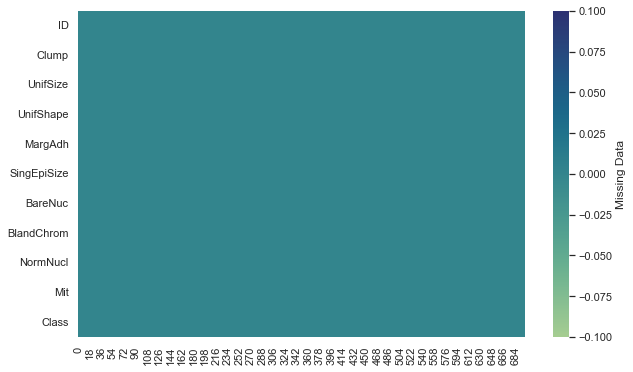

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(cell_df.isna().transpose(),
            cmap="crest",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)


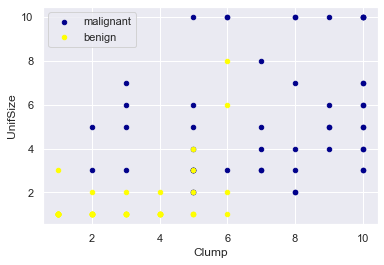

In [8]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Data pre-processing and selection


Let's first look at columns data types:


In [9]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [10]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [11]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.


In [12]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset


We split our dataset into train and test set:


In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


### Linear Kernal

In [14]:
from sklearn import svm
model = svm.SVC(kernel="linear")
model.fit(X_train, y_train) 

SVC(kernel='linear')

After being fitted, the model can then be used to predict new values:


In [15]:
yhat = model.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>


### Classfication report

In [16]:
from sklearn.metrics import classification_report

target_names = ["benig","malignant"]
print(classification_report(y_test, yhat, target_names=target_names))


              precision    recall  f1-score   support

       benig       1.00      0.94      0.97        90
   malignant       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



In [17]:
from sklearn.metrics import confusion_matrix
# y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, yhat)
cm

array([[85,  5],
       [ 0, 47]], dtype=int64)

### confusion_matrix

Text(39.5, 0.5, 'Truth')

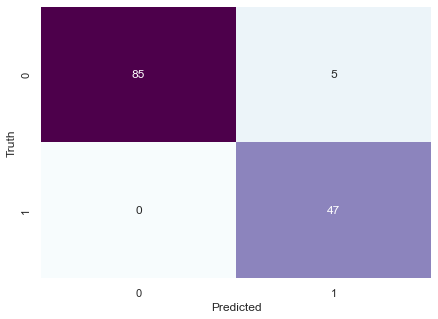

In [18]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap='BuPu')
plt.xlabel('Predicted')
plt.ylabel('Truth')

You can also easily use the **f1\_score** from sklearn library:


In [19]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Let's try the jaccard index for accuracy:


In [20]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.9444444444444444

In [21]:
model.score(X_test,y_test)

0.9635036496350365

### Polynomial kernal

In [22]:
from sklearn import svm
model = svm.SVC(kernel="poly")
model.fit(X_train, y_train) 

SVC(kernel='poly')

In [23]:
yhat = model.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

In [24]:
model.score(X_test,y_test)

0.9708029197080292

In [25]:
from sklearn.metrics import classification_report

target_names = ["benig","malignant"]
print(classification_report(y_test, yhat, target_names=target_names))


              precision    recall  f1-score   support

       benig       1.00      0.96      0.98        90
   malignant       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137



In [26]:
from sklearn.metrics import confusion_matrix
# y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, yhat)
cm

array([[86,  4],
       [ 0, 47]], dtype=int64)

Text(39.5, 0.5, 'Truth')

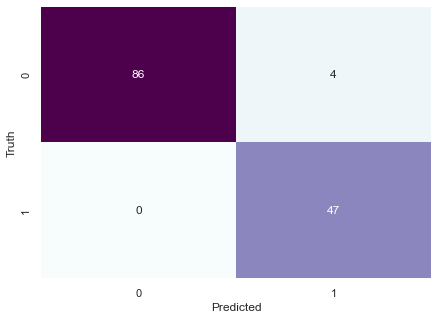

In [27]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap='BuPu')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Radial basis function  kernal

In [28]:
from sklearn import svm
model = svm.SVC(kernel="rbf")
model.fit(X_train, y_train) 

SVC()

In [29]:
yhat = model.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

In [30]:
model.score(X_test,y_test)

0.9635036496350365

In [31]:
from sklearn.metrics import classification_report

target_names = ["benig","malignant"]
print(classification_report(y_test, yhat, target_names=target_names))


              precision    recall  f1-score   support

       benig       1.00      0.94      0.97        90
   malignant       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



In [32]:
from sklearn.metrics import confusion_matrix
# y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, yhat)
cm

array([[85,  5],
       [ 0, 47]], dtype=int64)

Text(39.5, 0.5, 'Truth')

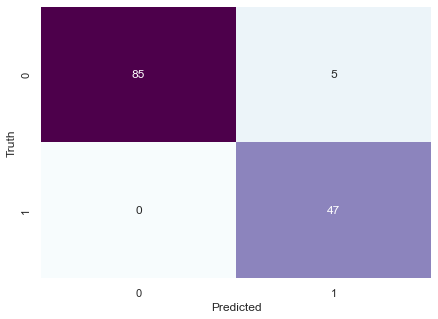

In [33]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True,fmt='d',cbar=False,cmap='BuPu')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Conclusion 
<li>Linear kernal accuracy: 0.9635036496350365
<li>Polynomial kernal accuracy:0.9708029197080292
<li>Radial basis function kernal accuracy :0.9635036496350365